#### Script for optimization of a single topology

In [1]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints, CalculateMultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz,get_steped_round_trajectory, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory,get_workspace_trajectory,get_horizontal_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward, ZRRReward, MinForceReward,MinManipulabilityReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT

In [2]:
1350-540-165 - 335


310

### Parametrization

#### 1) mechanism configuration

-0.14849242404917498 -0.14849242404917498 0.2757716446627535


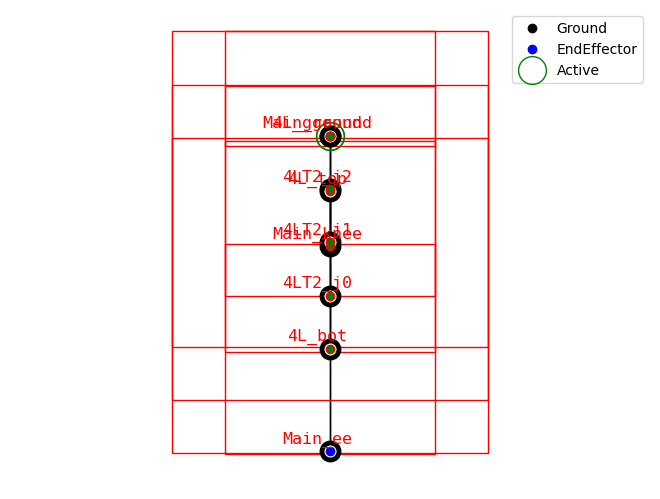

In [3]:
anlge = np.deg2rad(-45)
l1 = 0.21
l2 = 0.18

x_knee = l1 * np.sin(anlge)
y_knee = -l1 * np.cos(anlge)

y_ee = -y_knee + l2 * np.cos(anlge)
print(x_knee, y_knee, y_ee)

generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(-0.105, shift=0)
graph, constrain_dict = all_graphs[8]

thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G":body_density},
                              thickness={"default": thickness, "EE":0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
)

draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

#### 2) set optimization task

In [4]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.1, -0.29], 0.07, 0.2, 30, 60))
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.075, -0.28], step_height=0.05, step_width=0.15, n_points=50))
central_horizonatal = convert_x_y_to_6d_traj_xz(
    *get_horizontal_trajectory(-0.28, 0.15, 0, 50))
workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_steped_round_trajectory([0, -0.3], 0.02, 3, 100))

# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = AccelerationCapability(manipulability_key='Manip_Jacobian',
                                                 trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")
min_velocity = MinManipulabilityReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")

min_force = MinForceReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")
heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")
#soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [workspace_trajectory])
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step, central_horizonatal])


# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_trajectory(central_horizonatal, 1)
reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(min_velocity, 0, 1)
reward_manager.add_reward(heavy_lifting, 0, 1)
reward_manager.add_reward(min_force,1,1)

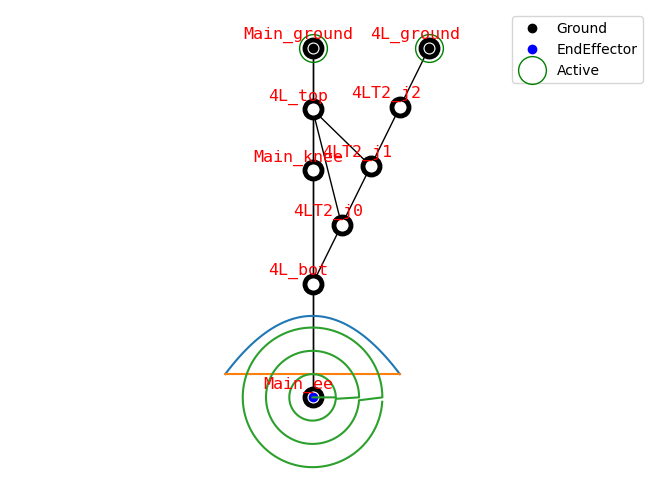

In [5]:
draw_joint_point(graph)

for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

#### Calculate rewards for initial graph.

In [5]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)

constrain_error,_ = soft_constrain.calculate_constrain_error(crag, fixed_robot, free_robot)
print(constrain_error)

if constrain_error == 0:
    total_reward, partial_rewards, multi_reward = reward_manager.calculate_total(fixed_robot=fixed_robot, free_robot=free_robot, motor=actuator)

    print(total_reward)
    print(partial_rewards)
    print(multi_reward)
    print(sum(multi_reward))

0.05088985937870529


In [6]:
# activate multiprocessing
N_PROCESS = 8
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)


In [7]:
from pymoo.algorithms.moo.age2 import AGEMOEA2

population_size = 32
n_generations = 20

# create the problem for the current optimization
problem = CalculateMultiCriteriaProblem(graph,builder, optimizing_joints, reward_manager, soft_constrain, elementwise_runner=runner, Actuator = actuator)

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 3,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })


[6.08620326e-07 6.08620326e-07 6.08620326e-07 6.08620326e-07]
[0.0022777 0.0022777 0.0022777 0.0022777]
[1.e-06 1.e-06 1.e-06 1.e-06]
[20.966035642317518, 0.18903553, 0.845384204390855, 0.19225617]
[0.04121515 0.04121515 0.04121515 0.04121515]
[0.00497817 0.00497817 0.00497817 0.00497817]
[14.715452206537014, 0.12871392, 1.5525548792701191, 0.12751019]
[5.e-07 5.e-07 5.e-07 5.e-07]
[16.45923387229088, 0.2089923, 0.9410372321058579, 0.21186146]
[0.01540136 0.01540136 0.01540136 0.01540136]
[0.07792083 0.07792083 0.07792083 0.07792083]
[0.04099891 0.04099891 0.04099891 0.04099891]
[1.e-06 1.e-06 1.e-06 1.e-06]
[11.982966965633103, 0.13853765, 1.6732988750934463, 0.13968171]
[0.03955945 0.03955945 0.03955945 0.03955945]
[0.01438017 0.01438017 0.01438017 0.01438017]
[0.03878786 0.03878786 0.03878786 0.03878786]
[0.02759777 0.02759777 0.02759777 0.02759777]
[0.02996345 0.02996345 0.02996345 0.02996345]
[0.01172521 0.01172521 0.01172521 0.01172521]
[7.04437256e-07 7.04437256e-07 7.04437256e-

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       32 |      6 |             - |             -
     2 |       64 |     12 |  0.4737270947 |         ideal
     3 |       96 |     20 |  0.3483393045 |         ideal
     4 |      128 |     29 |  0.0866687072 |         ideal
     5 |      160 |     32 |  0.0230041260 |         ideal
     6 |      192 |     32 |  0.0143068358 |         ideal
     7 |      224 |     32 |  0.0741636160 |         ideal
     8 |      256 |     32 |  0.0733102767 |         ideal
     9 |      288 |     32 |  0.1426245016 |         ideal
    10 |      320 |     32 |  0.1287347096 |         ideal
    11 |      352 |     32 |  0.1077346510 |         nadir
    12 |      384 |     32 |  0.0181944995 |         ideal
    13 |      416 |     32 |  0.0168711428 |         ideal
    14 |      448 |     32 |  0.1767263169 |         ideal
    15 |      480 |     32 |  0.0207196551 |         ideal
    16 |      512 |     32 |  0.0939979900 |         ide

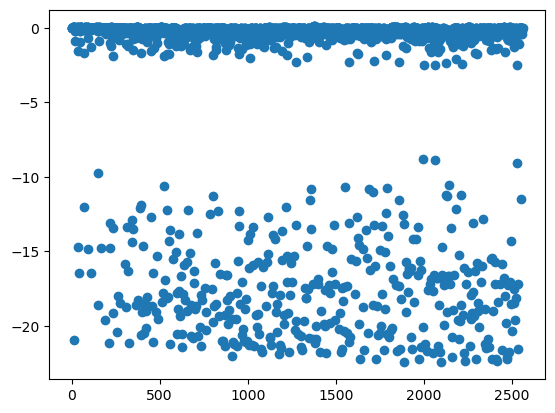

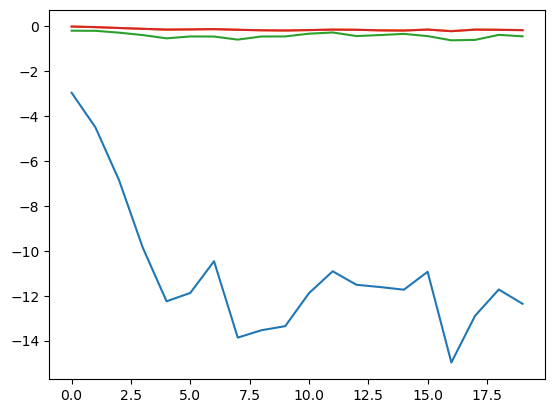

In [8]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

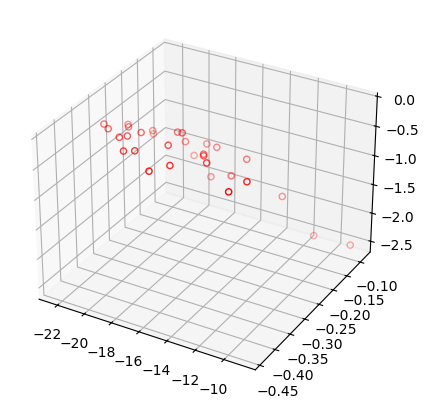

In [14]:
F = res.F
xl, xu = problem.bounds()
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d',)
ax.scatter(F[:,0],F[:,1], F[:,2], facecolors='none', edgecolors='r')

Scale f1: [-22.393941473607914, -8.832292605145545]
Scale f2: [-0.43857288360595703, -0.08775383979082108]


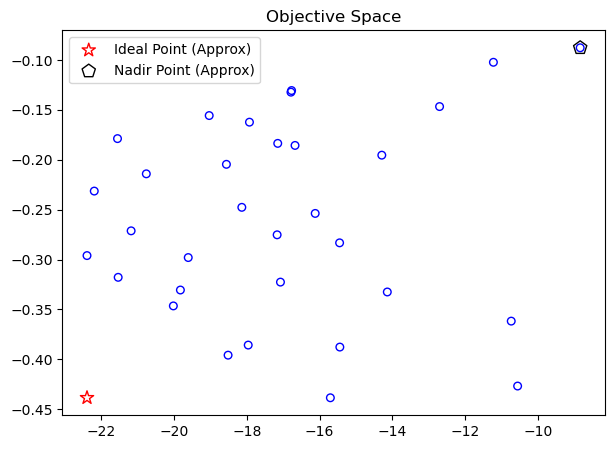

In [15]:
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title("Objective Space")
plt.legend()
plt.show()


Best regarding ASF: Point 
i = 24
F = [-17.96098181  -0.38574734  -0.16861345  -0.35989362]


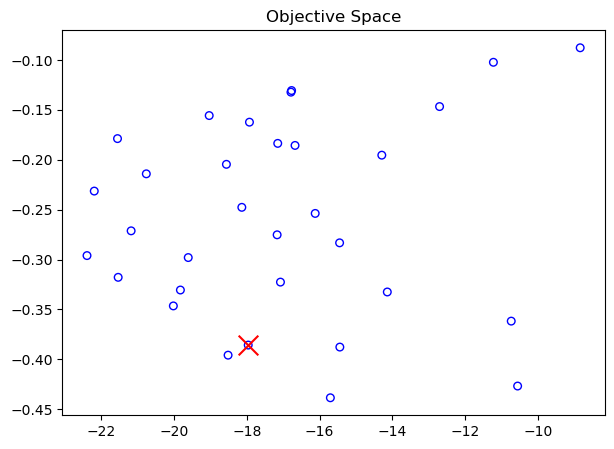

In [13]:
from pymoo.decomposition.asf import ASF

nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
weights = np.array([0.2, 0.6, 0.1, 0.1])


decomp = ASF()
i = decomp.do(nF, 1/weights).argmin()

print("Best regarding ASF: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()



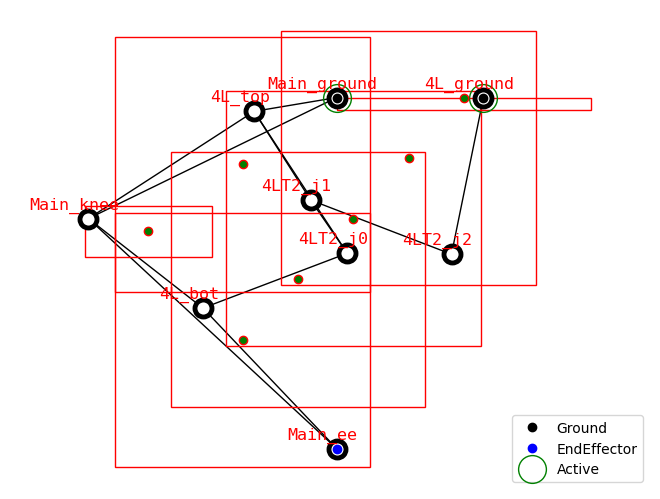

In [16]:
# best_id = np.argmin(optimizer.history["F"])
# best_x = optimizer.history["X"][best_id]
# best_reward = optimizer.history["F"][best_id]
# print("The minimum result in optimization task:", best_reward)

best_x = res.X[i]
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
visualize_constrains(problem.graph, constrain_dict)
problem.mutate_JP_by_xopt(best_x)

In [17]:
histF = np.array(optimizer.history["F"])
validF1 = histF[:,0][histF[:,0]<0]
validF2 = histF[:,1][histF[:,1]<0]

In [27]:
np.mean(histF[histF[:,0]>0]), np.std(histF[histF[:,0]>0])


(0.011307799100279632, 0.017728139938338258)

In [18]:
worstF1_id = np.argmax(validF1)
worstF2_id = np.argmax(validF2)
worst_reward2 = validF2[worstF2_id]
worst_reward1 = validF1[worstF1_id]
print('The maximum result in optimization task:', worst_reward1, worst_reward2)

The maximum result in optimization task: -8.8178692867619 -0.08775383979082108


The minimum result in optimization task: F1: -22.448181603955053  F2:  -0.43857288360595703  F: weights: [0.2 0.6 0.1 0.1] [-17.96098181  -0.38574734  -0.16861345  -0.35989362]


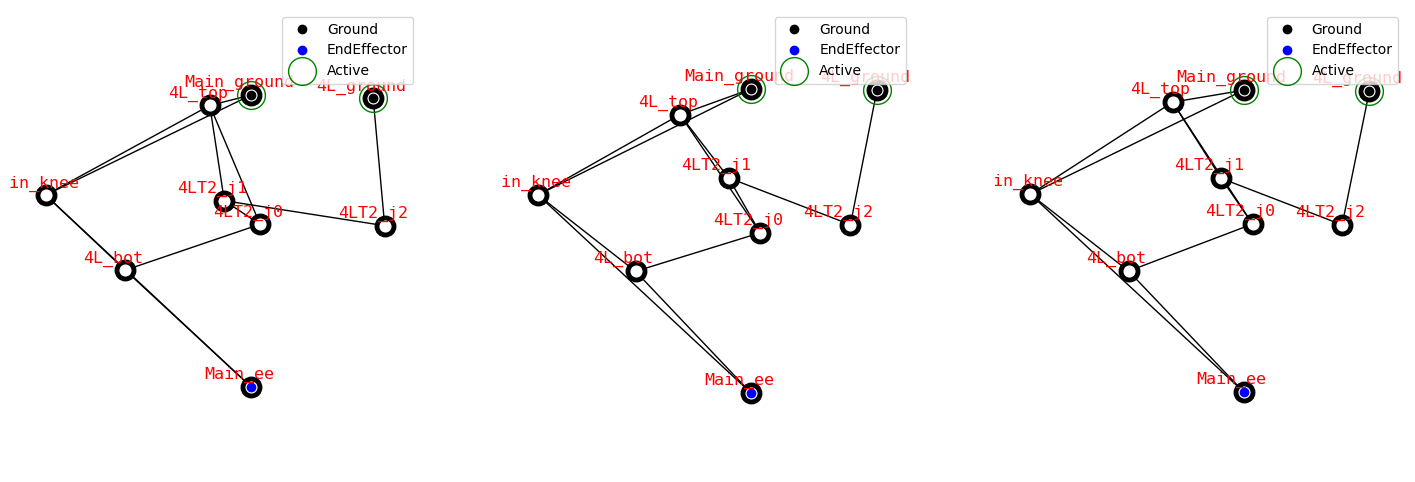

In [19]:
bestF1_id = np.argmin(validF1)
bestF2_id = np.argmin(validF2)
bestF1_x = optimizer.history["X"][np.where(histF[:,0]==validF1[bestF1_id])[0][0]]
bestF1_reward = validF1[bestF1_id]
bestF2_x = optimizer.history["X"][np.where(histF[:,1]==validF2[bestF2_id])[0][0]]
bestF2_reward = validF2[bestF2_id]
print("The minimum result in optimization task: F1:", bestF1_reward, " F2: ", bestF2_reward, f" F: weights: {weights}", F[i])

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
problem.mutate_JP_by_xopt(bestF1_x)
draw_joint_point(problem.graph)
plt.subplot(1, 3, 2)
problem.mutate_JP_by_xopt(bestF2_x)
draw_joint_point(problem.graph)
plt.subplot(1, 3, 3)
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

In [20]:
best_reward_decomposition = optimizer.history["Fs"][np.argmin(histF[:,1])]
problem.mutate_JP_by_xopt(bestF2_x)
best_reward_decomposition

array([15.70194631,  0.43857288,  0.11793409,  0.40236446])

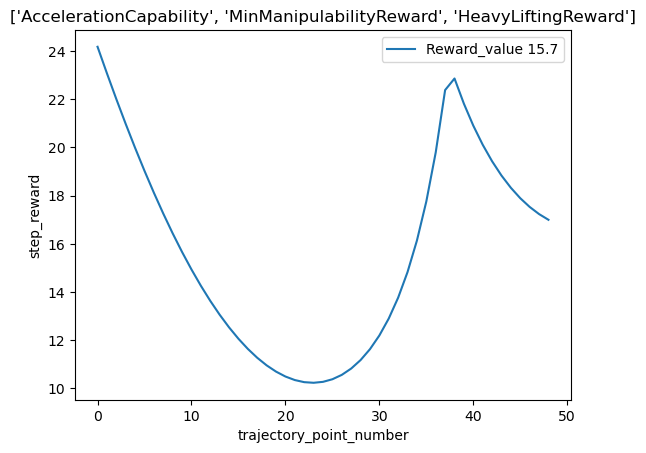

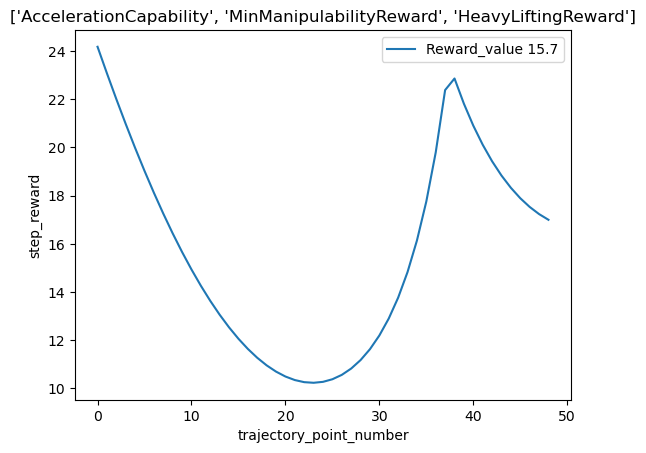

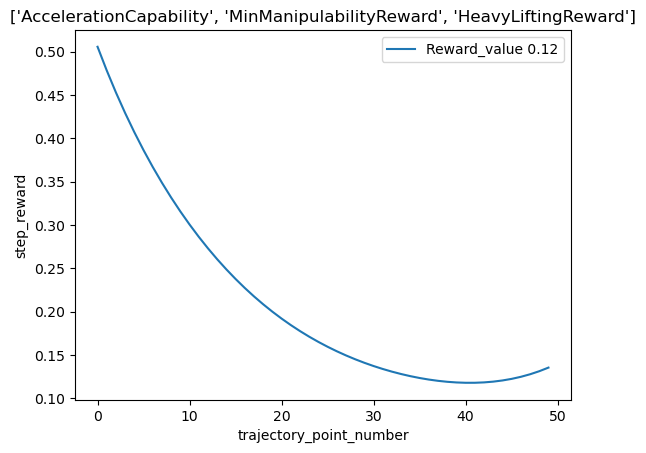

In [21]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)

reward_decomposition = best_reward_decomposition[0]
trajectory = reward_manager.trajectories[0]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title([rew[0].__class__.__name__ for rew in reward_manager.rewards[0]])
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

reward_decomposition = best_reward_decomposition[0]
trajectory = reward_manager.trajectories[0]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title([rew[0].__class__.__name__ for rew in reward_manager.rewards[0]])
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

reward_decomposition = best_reward_decomposition[0]
trajectory = reward_manager.trajectories[0]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title([rew[0].__class__.__name__ for rew in reward_manager.rewards[0]])
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

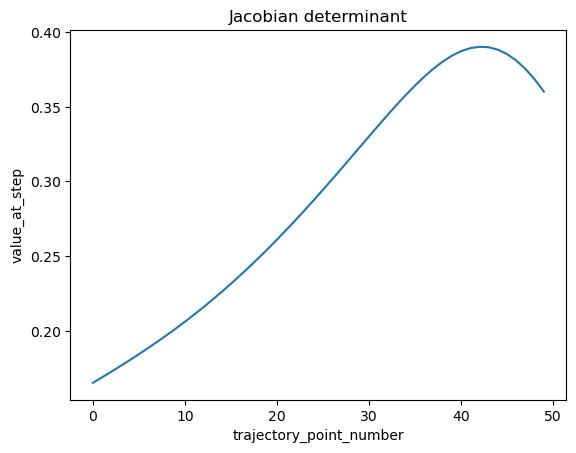

In [22]:
plt.plot(point_criteria_vector["MANIP"])
plt.xlabel('trajectory_point_number')
plt.ylabel('value_at_step')
plt.title('Jacobian determinant')
plt.show()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


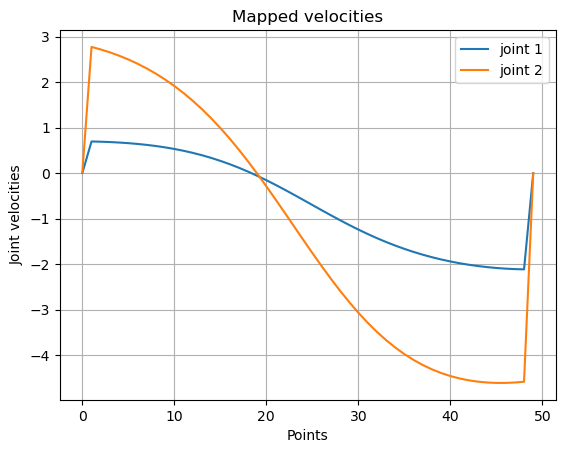

In [23]:
from auto_robot_design.pinokla.criterion_agregator import calculate_quasi_static_simdata
from pinocchio.visualize import MeshcatVisualizer
import meshcat

fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)

problem.mutate_JP_by_xopt(best_x)
des_traj_6d =reward_manager.trajectories[0]

viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
viz.viewer = meshcat.Visualizer().open()
viz.clean()
viz.loadViewerModel()
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
res_dict_free, res_dict_fixed = calculate_quasi_static_simdata(free_robot, fixed_robot, crag.end_effector_name, des_traj_6d, viz)

des_traj_6d_tangent = np.diff(des_traj_6d, axis=0)
for i in range(1, len(des_traj_6d_tangent)):
    des_traj_6d_tangent[i] = des_traj_6d_tangent[i] / np.linalg.norm(des_traj_6d_tangent[i])
arr_Jclosed = res_dict_fixed["J_closed"] 

des_traj_6d_tangent = np.vstack([des_traj_6d_tangent, np.zeros(6)])

q_mapped = np.zeros((len(des_traj_6d_tangent), 2))
for i in range(len(des_traj_6d_tangent)):
    q_mapped[i] = np.linalg.pinv(arr_Jclosed[i]) @ des_traj_6d_tangent[i]

q_mapped[:,0] = np.array([q_mapped[i,0] if np.abs(q_mapped[i,0]) <= 10 else 10 for i in range(len(q_mapped))])
q_mapped[:,1] = np.array([q_mapped[i,1] if np.abs(q_mapped[i,1]) <= 10 else 10 for i in range(len(q_mapped))])
plt.figure()
plt.plot(q_mapped[:, 0])
plt.plot(q_mapped[:, 1])
plt.title("Mapped velocities")
plt.xlabel("Points")
plt.ylabel("Joint velocities")
plt.legend(["joint 1", "joint 2"])
plt.grid(True)
plt.show()

In [ ]:
# point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, workspace_trajectory)

# reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
# reward_vector = np.array(reward_list)
# plt.plot(reward_vector)
# plt.xlabel('trajectory_point_number')
# plt.ylabel('step_reward')
# plt.title('HeavyLifting')
# plt.legend([f'Reward_value {round(reward,2)}'])
# plt.show()

# print(len(reward_vector))
# reward_vector=np.array(np.split(reward_vector, 51))
# for i, _ in enumerate(reward_vector):
#     if not i%2:
#         reward_vector[i] = np.flip(reward_vector[i])
